In [3]:
!pip install scikit-image

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

2025-04-23 21:44:03.860404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745444644.914859    3001 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745444645.224005    3001 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745444647.996538    3001 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745444647.996582    3001 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745444647.996585    3001 computation_placer.cc:177] computation placer alr

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


2025-04-23 21:44:24.912127: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Generator Model

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

# Discriminator Model

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [16]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [18]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

In [19]:
import time
import tensorflow as tf

class CustomLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        steps = self.params['steps']
        step_time = epoch_time / steps
        print(f"{steps}/{steps} ━━━━━━━━━━━━━━━━━━━━ "
              f"{int(epoch_time)}s {int(step_time * 1000)}ms/step - "
              f"accuracy: {logs['accuracy']:.4f} - loss: {logs['loss']:.4f} - "
              f"val_accuracy: {logs['val_accuracy']:.4f} - val_loss: {logs['val_loss']:.2f}")

    def on_train_end(self, logs=None):
        self.total_train_time = time.time() - self.train_start_time


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 221s 941ms/step - gen_loss: 1.6765 - disc_loss: 0.4136
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 214s 913ms/step - gen_loss: 0.7406 - disc_loss: 1.4444
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 213s 909ms/step - gen_loss: 0.8212 - disc_loss: 1.2028
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 214s 913ms/step - gen_loss: 0.7121 - disc_loss: 1.6708
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 213s 908ms/step - gen_loss: 0.6756 - disc_loss: 1.4864
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 213s 909ms/step - gen_loss: 0.7850 - disc_loss: 1.3389
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 213s 909ms/step - gen_loss: 0.9485 - disc_loss: 1.1226
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 212s 902ms/step - gen_loss: 0.6919 - disc_loss: 1.5603
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 214s 914ms/step - gen_loss: 0.9177 - disc_loss: 1.1665
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 213s 907ms/step - gen_loss: 0.9138 - disc_loss: 1.2128

--- Final Metrics ---
Total Training Time: 2145.

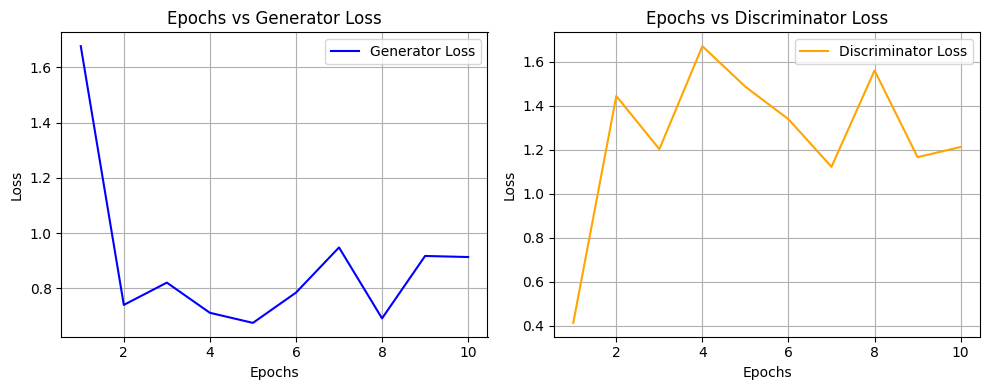

In [20]:
import matplotlib.pyplot as plt

def train(dataset, epochs):
    total_train_time = 0
    epoch_times = []

    gen_losses = []
    disc_losses = []

    steps_per_epoch = tf.data.experimental.cardinality(dataset).numpy()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        start = time.time()

        for i, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)

        epoch_time = time.time() - start
        epoch_times.append(epoch_time)
        total_train_time += epoch_time

        # Save last loss of this epoch
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        step_time = epoch_time / steps_per_epoch
        print(f"{steps_per_epoch}/{steps_per_epoch} ━━━━━━━━━━━━━━━━━━━━ "
              f"{int(epoch_time)}s {int(step_time * 1000)}ms/step - "
              f"gen_loss: {gen_loss:.4f} - disc_loss: {disc_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    generate_and_save_images(generator, epochs, seed)

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    avg_step_time = avg_epoch_time / steps_per_epoch

    print("\n--- Final Metrics ---")
    print(f"Total Training Time: {total_train_time:.2f} seconds")
    print(f"Average Epoch Time: {avg_epoch_time:.2f} seconds")
    print(f"Step Time (approximate per batch): {avg_step_time:.4f} seconds")

    # Plotting losses
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, gen_losses, label='Generator Loss', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epochs vs Generator Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, disc_losses, label='Discriminator Loss', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epochs vs Discriminator Loss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    
    plt.show()

train(train_dataset, EPOCHS)

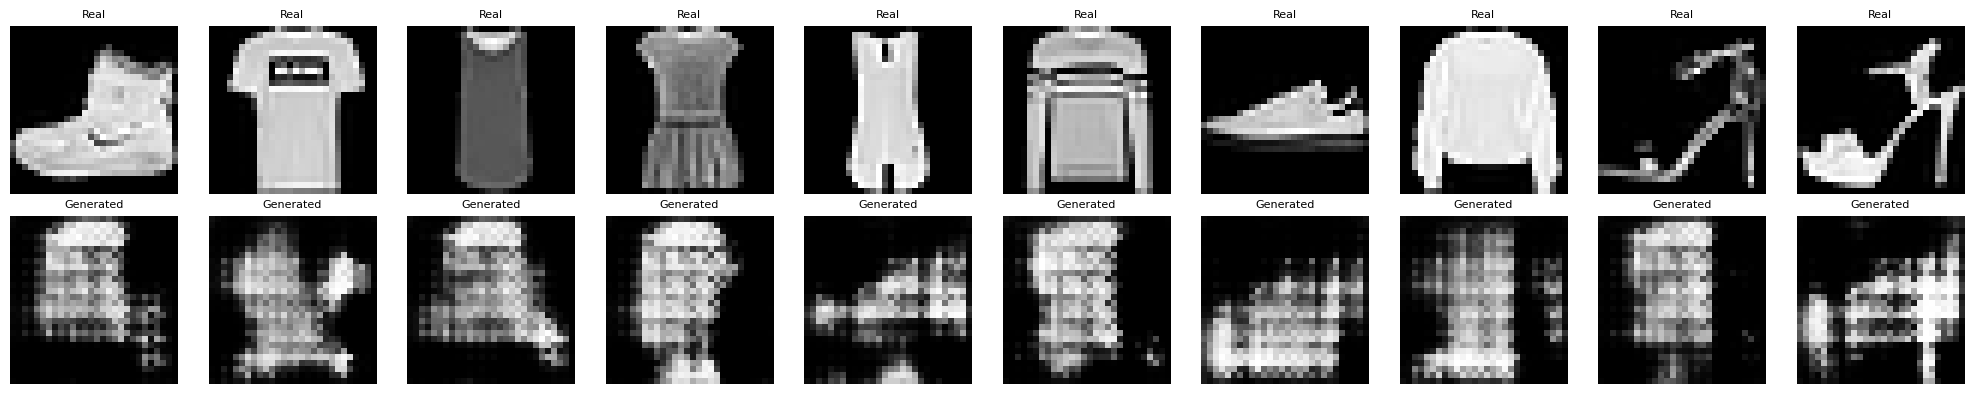

In [39]:
import matplotlib.pyplot as plt
import numpy as np

real_images = train_images[:10]  

noise = tf.random.normal([10, noise_dim])
generated_images = generator(noise, training=False)

real_images = (real_images * 127.5 + 127.5) / 255.0
generated_images = (generated_images * 127.5 + 127.5) / 255.0

plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(real_images[i].reshape(28, 28), cmap='gray')
    plt.title("Real", fontsize=8)
    plt.axis('off')

for i in range(10):
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(generated_images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title("Generated", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.savefig('real_vs_generated.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(real_images, generated_images):
    scores = []
    for i in range(10):
        real = real_images[i].squeeze()
        gen = generated_images[i].numpy().squeeze()
        scores.append(ssim(real, gen, data_range=2.0))
    return np.mean(scores)

ssim_score = calculate_ssim(real_images, generated_images)
print(f"SSIM Score: {ssim_score:.4f}")